
# Sentiment time-series visualization

- Plotting average daily/hourly sentiment scores across different sources (Twitter, news)
- Overlay NVDA closing price, VIX, volume, etc. on the same graph to see their rough resonance or lagged relationship

In [1]:
# read data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取已经对齐的数据
df = pd.read_csv("../2_data/sentiment_price_vix_inner_aligned.csv", index_col=0)
df = df.reset_index()
df = df.rename(columns={"index": "date"})

# 转换为 datetime 类型
df['date'] = pd.to_datetime(df['date'])  



# 检查结果
print(df.columns)
print(df.head())


Index(['date', 'avg_sentiment_score', 'tweet_count', 'sentiment_std',
       'model_type', 'nvda_open', 'nvda_high', 'nvda_low', 'nvda_close',
       'nvda_return', 'vix_close'],
      dtype='object')
        date  avg_sentiment_score  tweet_count  sentiment_std  \
0 2019-01-02            -0.028037          214       0.463867   
1 2019-01-03            -0.021352          281       0.470076   
2 2019-01-04             0.000000          210       0.403335   
3 2019-01-07             0.055147          272       0.421615   
4 2019-01-08            -0.029333          375       0.409373   

        model_type  nvda_open  nvda_high  nvda_low  nvda_close  nvda_return  \
0  FinBERT+RoBERTa    3.26600    3.46200   3.25125     3.40550     0.020374   
1  FinBERT+RoBERTa    3.34475    3.37900   3.19225     3.19975    -0.060417   
2  FinBERT+RoBERTa    3.27350    3.44325   3.24250     3.40475     0.064068   
3  FinBERT+RoBERTa    3.46250    3.62225   3.41075     3.58500     0.052941   
4  FinBERT+Ro

In [2]:
# only use FinBERT+RoBERTa
df = df[df['model_type'] == 'FinBERT+RoBERTa']

df['sentiment_ma7'] = df['avg_sentiment_score'].rolling(window=7).mean()
df['nvda_close_ma7'] = df['nvda_close'].rolling(window=7).mean()
df['vix_close_ma7'] = df['vix_close'].rolling(window=7).mean()



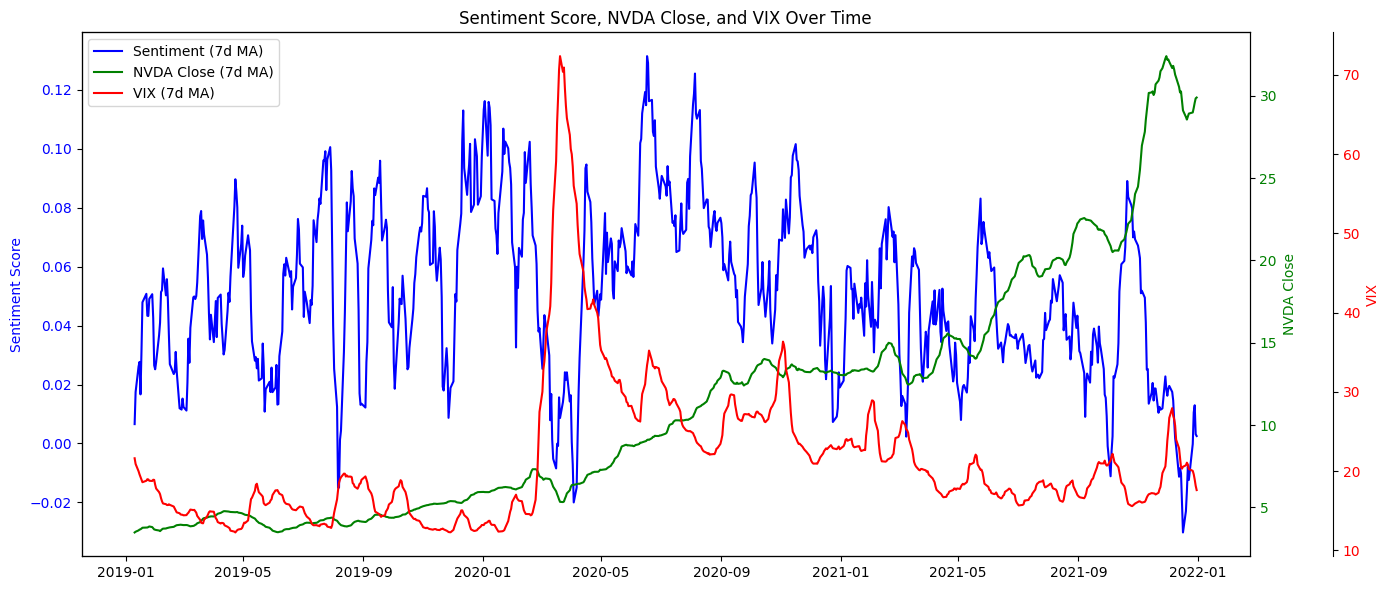

In [3]:
# visualization

fig, ax1 = plt.subplots(figsize=(14, 6))
plt.title("Sentiment Score, NVDA Close, and VIX Over Time")

# sentiment score
ax1.plot(df['date'], df['sentiment_ma7'], color='blue', label='Sentiment (7d MA)')
ax1.set_ylabel('Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


# nvda close
ax2 = ax1.twinx()
ax2.plot(df['date'], df['nvda_close_ma7'], color='green', label='NVDA Close (7d MA)')
ax2.set_ylabel('NVDA Close', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# vix
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df['date'], df['vix_close_ma7'], color='red', label='VIX (7d MA)')
ax3.set_ylabel('VIX', color='red')
ax3.tick_params(axis='y', labelcolor='red')

# legend
lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

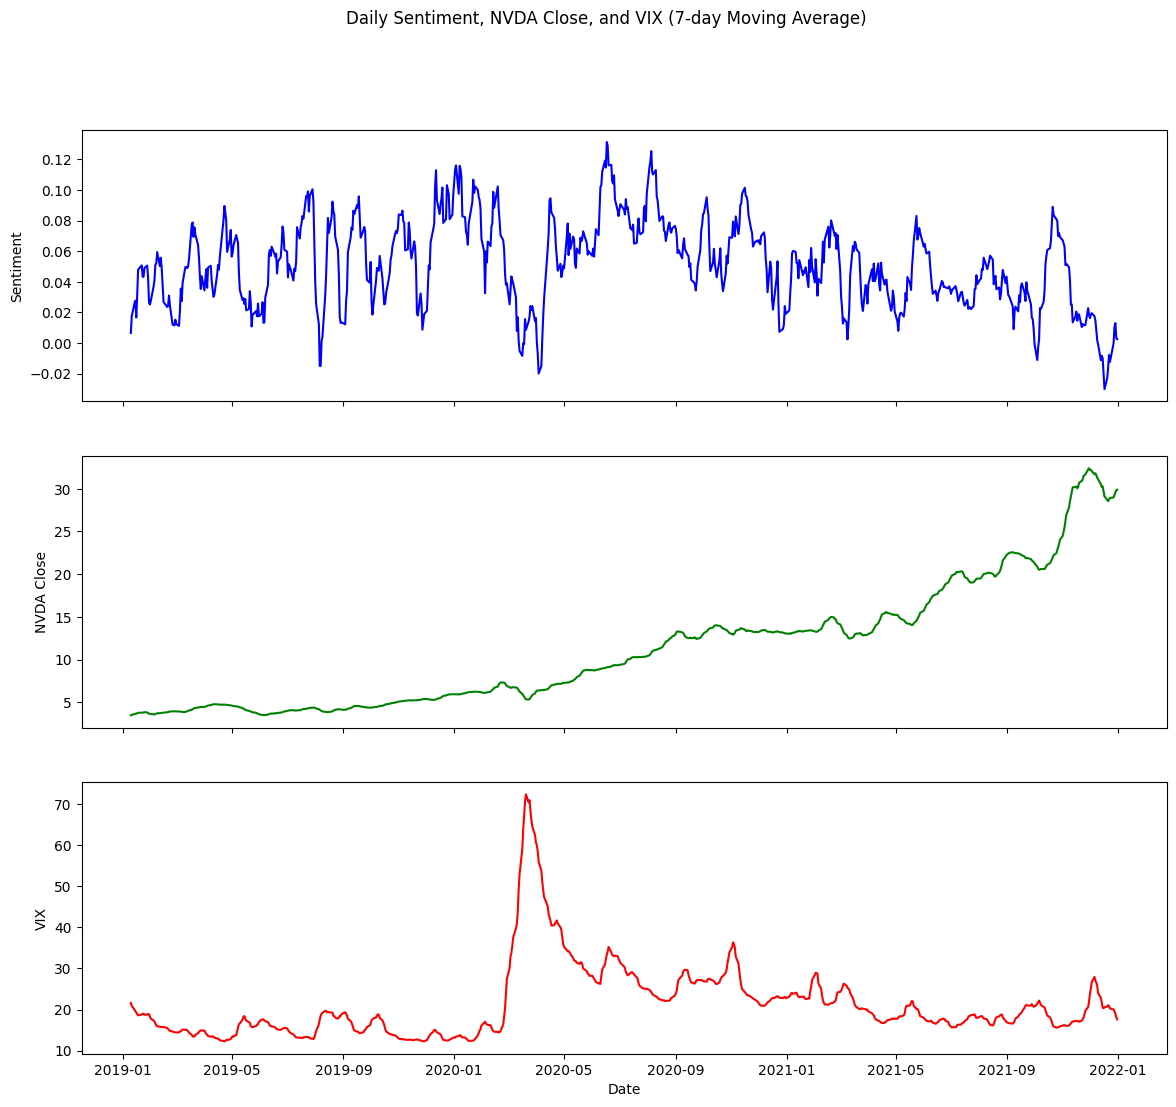

In [4]:
# Calculate moving averages with 7-day window
df['sentiment_smooth'] = df['avg_sentiment_score'].rolling(window=7).mean()
df['nvda_smooth'] = df['nvda_close'].rolling(window=7).mean()
df['vix_smooth'] = df['vix_close'].rolling(window=7).mean()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
ax1.plot(df['date'], df['sentiment_smooth'], label='Sentiment (7-day MA)', color='blue')
ax1.set_ylabel('Sentiment')
ax2.plot(df['date'], df['nvda_smooth'], label='NVDA Close (7-day MA)', color='green')
ax2.set_ylabel('NVDA Close')
ax3.plot(df['date'], df['vix_smooth'], label='VIX (7-day MA)', color='red')
ax3.set_ylabel('VIX')
plt.xlabel('Date')
plt.suptitle('Daily Sentiment, NVDA Close, and VIX (7-day Moving Average)')
plt.show()

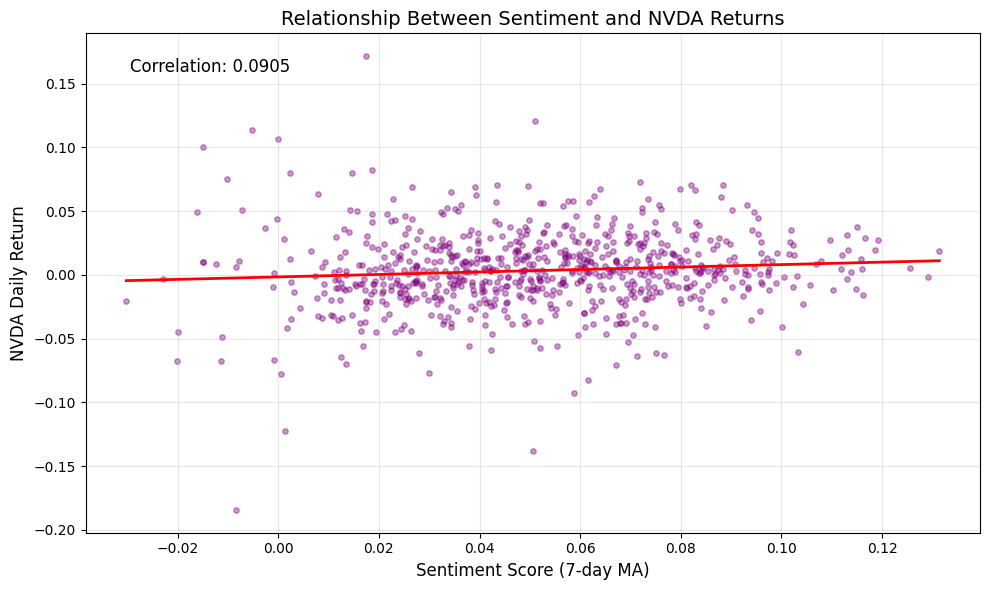

In [5]:
# 4. Sentiment and return relationship
def plot_sentiment_return_relation():
    # Remove missing values
    valid_data = df.dropna(subset=['sentiment_ma7', 'nvda_return']).copy()
    
    # Scatter plot with regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(valid_data['sentiment_ma7'], valid_data['nvda_return'], 
               alpha=0.4, color='purple', s=15)
    
    # Add regression line
    z = np.polyfit(valid_data['sentiment_ma7'], valid_data['nvda_return'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(valid_data['sentiment_ma7'].min(), 
                         valid_data['sentiment_ma7'].max(), 100)
    plt.plot(x_range, p(x_range), 'r-', linewidth=2)
    
    # Calculate correlation
    corr = valid_data['sentiment_ma7'].corr(valid_data['nvda_return'])
    plt.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=plt.gca().transAxes, 
           fontsize=12, verticalalignment='top')
    
    plt.xlabel('Sentiment Score (7-day MA)', fontsize=12)
    plt.ylabel('NVDA Daily Return', fontsize=12)
    plt.title('Relationship Between Sentiment and NVDA Returns', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


plot_sentiment_return_relation()


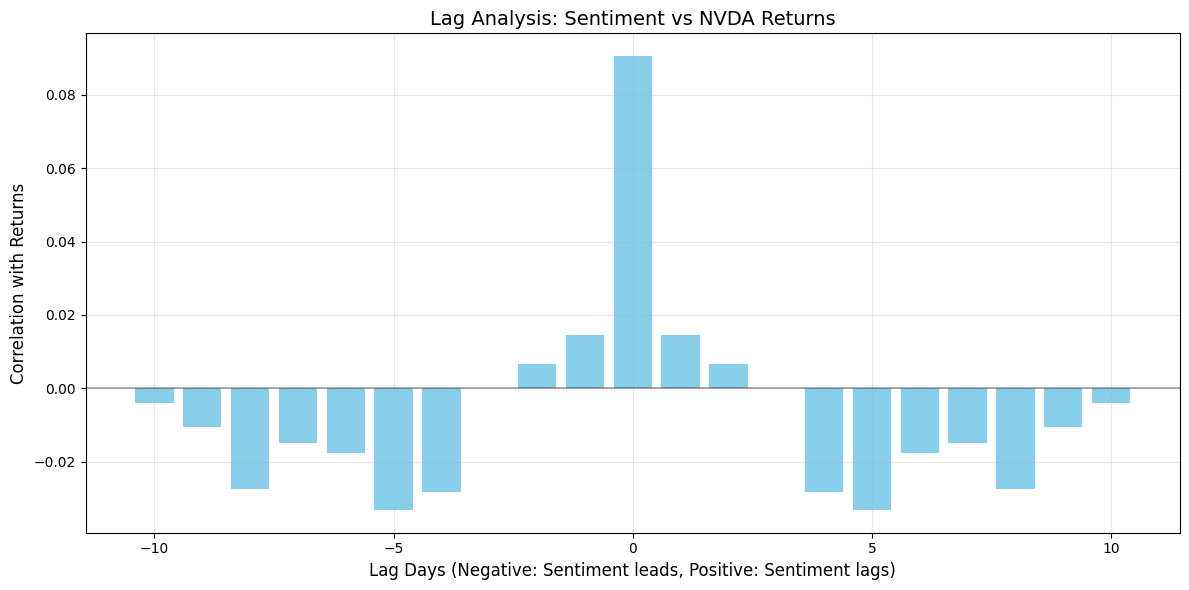

In [6]:
# Sentiment lag analysis
def plot_lag_analysis():
    max_lag = 10
    correlations = []
    
    for lag in range(-max_lag, max_lag+1):
        if lag < 0:
            sentiment_shifted = df['sentiment_ma7'].shift(-lag)
            price = df['nvda_return']
        else:
            sentiment_shifted = df['sentiment_ma7'].shift(lag)
            price = df['nvda_return']
        
        # Calculate correlation
        corr = sentiment_shifted.corr(price)
        correlations.append((lag, corr))
    
    lags, corrs = zip(*correlations)
    
    plt.figure(figsize=(12, 6))
    plt.bar(lags, corrs, color='skyblue')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Lag Days (Negative: Sentiment leads, Positive: Sentiment lags)', fontsize=12)
    plt.ylabel('Correlation with Returns', fontsize=12)
    plt.title('Lag Analysis: Sentiment vs NVDA Returns', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


plot_lag_analysis()

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=757, freq=None)
            avg_sentiment_score  tweet_count  sentiment_std       model_type  \
date                                                                           
2019-01-02            -0.028037          214       0.463867  FinBERT+RoBERTa   
2019-01-03            -0.021352          281       0.470076  FinBERT+RoBERTa   
2019-01-04             0.000000          210       0.403335  FinBERT+RoBERTa   
2019-01-07             0.055147          272       0.421615  FinBERT+RoBERTa   
2019-01-08            -0.029333          375       0.409

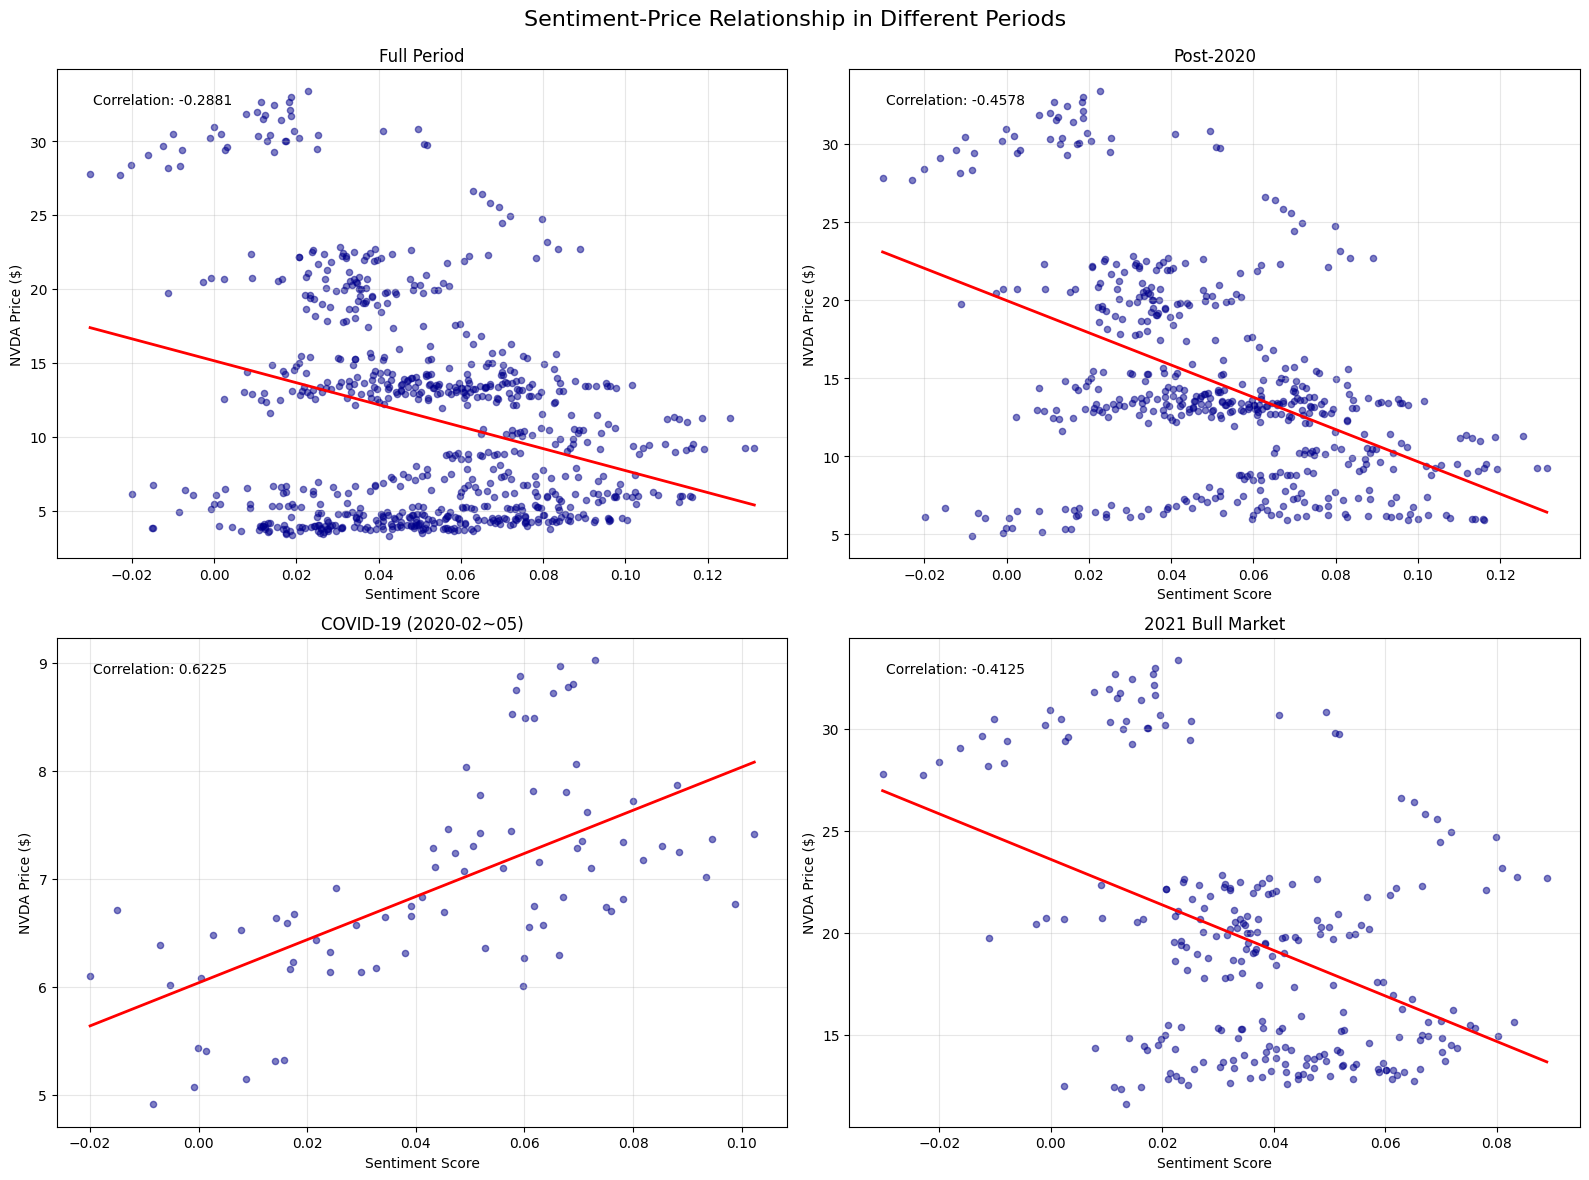

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = df.set_index('date')


# choose variables for granger causality test (must be no missing values)
df['nvda_return_5d'] = df['nvda_close'].pct_change(periods=5)

granger_df = df[["nvda_return_5d", "vix_close", "avg_sentiment_score"]].dropna()
print(df.index)
print(df.head())



# calculate 7-day moving average
window_size = 7
df['sentiment_ma7'] = df['avg_sentiment_score'].rolling(window=window_size).mean()
df['nvda_close_ma7'] = df['nvda_close'].rolling(window=window_size).mean()

full_period = df.copy()
recent_period = df.loc['2020-01-01':]
covid_period = df.loc['2020-02-01':'2020-05-31']
bull_period = df.loc['2021-01-01':'2021-12-31']


def plot_period_comparison():
    periods = {
        "Full Period": full_period,
        "Post-2020": recent_period,
        "COVID-19 (2020-02~05)": covid_period,
        "2021 Bull Market": bull_period
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, (title, period_data) in enumerate(periods.items()):
        ax = axes[i]
        # scatter plot
        ax.scatter(period_data['sentiment_ma7'], period_data['nvda_close'], 
              alpha=0.5, color='darkblue', s=20)
        # regression line
        valid = period_data.dropna(subset=['sentiment_ma7', 'nvda_close'])
        if len(valid) > 1:
            z = np.polyfit(valid['sentiment_ma7'], valid['nvda_close'], 1)
            p = np.poly1d(z)
            x_range = np.linspace(valid['sentiment_ma7'].min(), valid['sentiment_ma7'].max(), 100)
            ax.plot(x_range, p(x_range), 'r-', linewidth=2)
        # correlation coefficient
        corr = valid['sentiment_ma7'].corr(valid['nvda_close'])
        ax.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top')

        ax.set_title(title, fontsize=12)
        ax.set_xlabel('Sentiment Score', fontsize=10)
        ax.set_ylabel('NVDA Price ($)', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Sentiment-Price Relationship in Different Periods', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


plot_period_comparison()


# Causal Causality Analysis 
To study the causal relationship between sentiment, volatility (VIX) and NVDA stock returns, the classic Granger causality test is used. The goal is to answer the following question:

- Can market sentiment (e.g., social media sentiment scores) and market volatility (VIX) predict NVDA's future returns?

- Do NVDA returns in turn affect market sentiment and volatility?

- Is the dynamic relationship between these variables unidirectional or bidirectional? What are the lagged effects?


## Overall process organization

### 1. Data preparation and merging

- Read the daily data of VIX, NVDA price and sentiment score.

- Harmonize the date range and merge by date into a complete factor data table (factor_data.csv) containing:

- avg_sentiment_score (sentiment score)

- vix_close (VIX close)

- nvda_close (NVDA closing price)

- Other relevant financial indicators

### 2. Constructing Return Variables

- Calculate the future 5-day return of NVDA (nvda_return_5d) as an explanatory variable.

### 3. Granger causality test (positive)

- Test whether VIX and sentiment can Granger cause NVDA future returns (i.e., whether they have predictive power).

- Standardize the data and test them separately with lags of order 1 to 5, outputting the F-value and p-value for each order.

### 4. Granger causality test (reverse)

- Test whether NVDA returns Granger cause VIX and sentiment (i.e., whether returns feed back to affect sentiment and volatility).

- Again the test is performed with lags of order 1 to 5 and the output statistic.

### 5. Interpretation of Results and English Notes

- The Notebook has detailed English markdown annotations that explain the economic implications and statistical results of each step.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

In [9]:
import pandas as pd

# read three datasets
df_vix = pd.read_csv("../2_data/daily_vix.csv", parse_dates=["date"])
df_nvda = pd.read_csv("../2_data/daily_nvda.csv", parse_dates=["Date"]).rename(columns={"Date": "date"})
df_sentiscores = pd.read_csv("../2_data/daily_sentiment_combined.csv", parse_dates=["date"])

# filter date range
start_date = "2017-01-01"
end_date = "2021-12-31"
date_range = pd.date_range(start=start_date, end=end_date)
df_all = pd.DataFrame({"date": date_range})

# add prefix: VIX
df_vix = df_vix[df_vix["date"].between(start_date, end_date)]
df_vix = df_vix.rename(columns=lambda x: f"vix_{x}" if x != "date" else x)

# add prefix: NVDA
df_nvda.columns = [col.lower() for col in df_nvda.columns]
df_nvda = df_nvda[df_nvda["date"].between(start_date, end_date)]
df_nvda = df_nvda.rename(columns=lambda x: f"nvda_{x}" if x != "date" else x)

# sentiment data also filter date range
df_sentiscores = df_sentiscores[df_sentiscores["date"].between(start_date, end_date)]

# merge
df_merged = df_all.merge(df_sentiscores, on="date", how="left") \
                  .merge(df_vix, on="date", how="left") \
                  .merge(df_nvda, on="date", how="left")

# check missing values
print("Missing values per column:")
print(df_merged.isnull().sum())

# check merged data
print(df_merged.head())

# save result
df_merged.to_csv("../2_data/factor_data.csv", index=False)

Missing values per column:
date                     0
avg_sentiment_score    730
tweet_count            730
sentiment_std          730
model_type             730
vix_open               567
vix_high               567
vix_low                567
vix_close              567
nvda_open              818
nvda_high              818
nvda_low               818
nvda_close             818
nvda_volume            818
dtype: int64
        date  avg_sentiment_score  tweet_count  sentiment_std model_type  \
0 2017-01-01                  NaN          NaN            NaN        NaN   
1 2017-01-02                  NaN          NaN            NaN        NaN   
2 2017-01-03                  NaN          NaN            NaN        NaN   
3 2017-01-04                  NaN          NaN            NaN        NaN   
4 2017-01-05                  NaN          NaN            NaN        NaN   

   vix_open  vix_high  vix_low  vix_close  nvda_open  nvda_high  nvda_low  \
0       NaN       NaN      NaN        NaN       

In [10]:
# load merged data
df = pd.read_csv("../2_data/factor_data.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

# create target variable: future return (5-day return)
df["nvda_return_5d"] = df["nvda_close"].pct_change(5).shift(-5)

# choose variables for granger causality test (must be no missing values)
granger_df = df[["nvda_return_5d", "vix_close", "avg_sentiment_score"]].dropna()

# standardize data (optional, but can improve the stability of the test)
from sklearn.preprocessing import StandardScaler
granger_df_scaled = pd.DataFrame(StandardScaler().fit_transform(granger_df),
                                 columns=granger_df.columns,
                                 index=granger_df.index)

# Granger causality test: VIX → NVDA returns
print("VIX → NVDA returns:")
grangercausalitytests(granger_df_scaled[["nvda_return_5d", "vix_close"]], maxlag=5, verbose=True)

# Granger causality test: sentiment → NVDA returns
print("\nSentiment → NVDA returns:")
grangercausalitytests(granger_df_scaled[["nvda_return_5d", "avg_sentiment_score"]], maxlag=5, verbose=True)

VIX → NVDA returns:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1011  , p=0.7506  , df_denom=748, df_num=1
ssr based chi2 test:   chi2=0.1015  , p=0.7500  , df=1
likelihood ratio test: chi2=0.1015  , p=0.7500  , df=1
parameter F test:         F=0.1011  , p=0.7506  , df_denom=748, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.9341 , p=0.0000  , df_denom=745, df_num=2
ssr based chi2 test:   chi2=26.0418 , p=0.0000  , df=2
likelihood ratio test: chi2=25.5999 , p=0.0000  , df=2
parameter F test:         F=12.9341 , p=0.0000  , df_denom=745, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.7931 , p=0.0000  , df_denom=742, df_num=3
ssr based chi2 test:   chi2=38.7413 , p=0.0000  , df=3
likelihood ratio test: chi2=37.7726 , p=0.0000  , df=3
parameter F test:         F=12.7931 , p=0.0000  , df_denom=742, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=

/var/folders/rn/lc8n68_d7ld6yymqc_lsnrr00000gn/T/ipykernel_18193/282145061.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["nvda_return_5d"] = df["nvda_close"].pct_change(5).shift(-5)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(0.49417121856628476),
    np.float64(0.4822912215551751),
    np.float64(748.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.4961531886942244),
    np.float64(0.48119527193625034),
    np.int64(1)),
   'lrtest': (np.float64(0.4959893673769784),
    np.float64(0.4812676801661727),
    np.int64(1)),
   'params_ftest': (np.float64(0.4941712185662567),
    np.float64(0.4822912215551751),
    np.float64(748.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.8123987106992278),
    np.float64(0.444185015487648),
    np.float64(745.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.635702102078982),
    np.float64(0.44137913733362233),
    np.int64(2)),
   'lrtest': (np.float64(1.6339210103292316),
    np.float64(0.4417723807783055),
    np.int64(2)),
   'params_ftest': (np.float64(0.8123987106992295),
    np.float64(0.444185015487648),
    np.float64(745.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
      

In [11]:
# reverse causality test

df_merged['nvda_return'] = df_merged['nvda_close'].pct_change()
df_merged = df_merged.dropna(subset=['nvda_return'])  # remove NaN

from statsmodels.tsa.stattools import grangercausalitytests

# set max lag
max_lag = 5

# test: NVDA returns → VIX
print("NVDA returns → VIX:")
data_nvda_to_vix = df_merged[['vix_close', 'nvda_return']].dropna()
grangercausalitytests(data_nvda_to_vix, maxlag=max_lag, verbose=True)

# test: NVDA returns → sentiment
print("\nNVDA returns → sentiment:")
data_nvda_to_sentiment = df_merged[['avg_sentiment_score', 'nvda_return']].dropna()
grangercausalitytests(data_nvda_to_sentiment, maxlag=max_lag, verbose=True)

NVDA returns → VIX:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.3162 , p=0.0001  , df_denom=1003, df_num=1
ssr based chi2 test:   chi2=15.3620 , p=0.0001  , df=1
likelihood ratio test: chi2=15.2459 , p=0.0001  , df=1
parameter F test:         F=15.3162 , p=0.0001  , df_denom=1003, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1164  , p=0.8901  , df_denom=1000, df_num=2
ssr based chi2 test:   chi2=0.2340  , p=0.8896  , df=2
likelihood ratio test: chi2=0.2339  , p=0.8896  , df=2
parameter F test:         F=0.1164  , p=0.8901  , df_denom=1000, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6472  , p=0.1769  , df_denom=997, df_num=3
ssr based chi2 test:   chi2=4.9762  , p=0.1736  , df=3
likelihood ratio test: chi2=4.9639  , p=0.1745  , df=3
parameter F test:         F=1.6472  , p=0.1769  , df_denom=997, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:       

/var/folders/rn/lc8n68_d7ld6yymqc_lsnrr00000gn/T/ipykernel_18193/1283938686.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_merged['nvda_return'] = df_merged['nvda_close'].pct_change()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(0.2421401234248956),
    np.float64(0.6227635653566704),
    np.float64(1092.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.24280534354419478),
    np.float64(0.6221872495676004),
    np.int64(1)),
   'lrtest': (np.float64(0.24277842768970004),
    np.float64(0.6222065505567147),
    np.int64(1)),
   'params_ftest': (np.float64(0.2421401234249758),
    np.float64(0.6227635653564962),
    np.float64(1092.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.8767511334916283),
    np.float64(0.4164262015651259),
    np.float64(1089.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(1.7615532415791393),
    np.float64(0.4144609077028878),
    np.int64(2)),
   'lrtest': (np.float64(1.7601365401123985),
    np.float64(0.41475459539547865),
    np.int64(2)),
   'params_ftest': (np.float64(0.8767511334916052),
    np.float64(0.4164262015651765),
    np.float64(1089.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],


## 3. Results Evaluation and Analysis

In [12]:
df = pd.read_csv("../2_data/sentiment_price_vix_inner_aligned.csv", index_col=0)
df = df.reset_index()
df = df.rename(columns={"index": "date"})

# transform to datetime type
df['date'] = pd.to_datetime(df['date'])  
print(df.columns.tolist())


['date', 'avg_sentiment_score', 'tweet_count', 'sentiment_std', 'model_type', 'nvda_open', 'nvda_high', 'nvda_low', 'nvda_close', 'nvda_return', 'vix_close']


signal
 0    294
-1    222
 1    222
Name: count, dtype: int64


Backtest.run:   0%|          | 0/737 [00:00<?, ?bar/s]

Start                     2019-01-30 00:00:00
End                       2021-12-31 00:00:00
Duration                   1066 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]               756.27771
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
CAGR [%]                                  0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                      

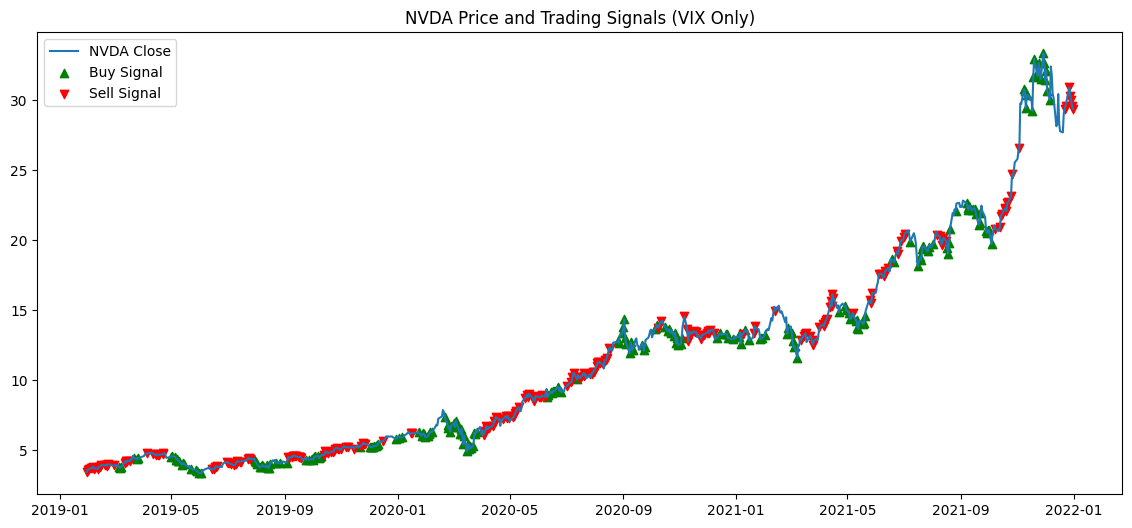

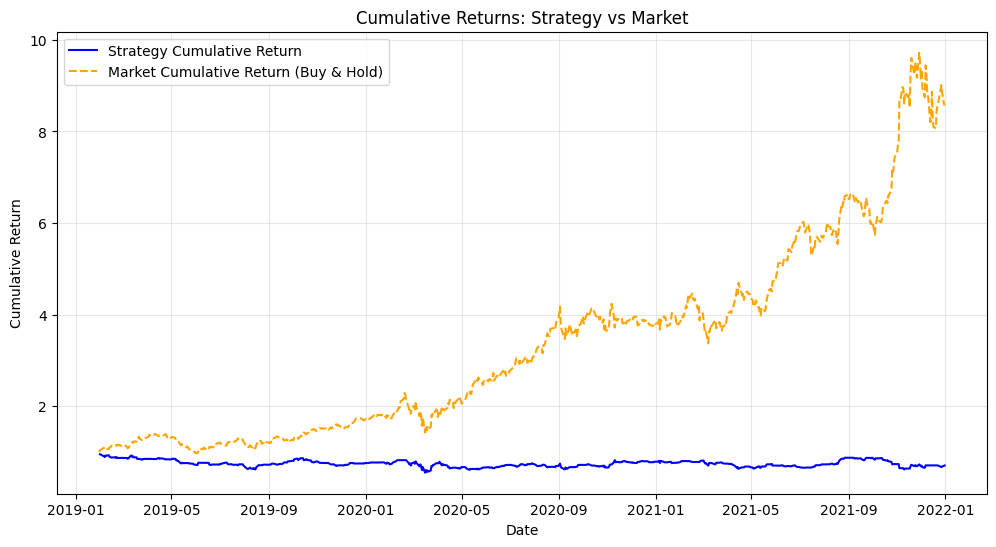

Final Cumulative Return (Strategy): 0.71
Final Cumulative Return (Market): 8.56


In [21]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import matplotlib.pyplot as plt

# 1. read
df = pd.read_csv("../2_data/sentiment_price_vix_inner_aligned.csv", index_col=0)
df = df.reset_index()
df = df.rename(columns={"index": "date"})


# 2. deal with missing value: forward and backward fill
df['vix_close'] = df['vix_close'].ffill().bfill()

# 3. calculate VIX z-score
window = 20
df['vix_z'] = (df['vix_close'] - df['vix_close'].rolling(window).mean()) / df['vix_close'].rolling(window).std()

# 4. NaN in vix_z(window days before rolling are NaN, just strike them out)
df = df.dropna(subset=['vix_z'])

# 5. signal generation
upper = df['vix_z'].quantile(0.7)
lower = df['vix_z'].quantile(0.3)
df['signal'] = 0
df.loc[df['vix_z'] > upper, 'signal'] = 1
df.loc[df['vix_z'] < lower, 'signal'] = -1

print(df['signal'].value_counts())  # signal distribution

# 6. building DataFrame for backtesting
bt_data = df[['date', 'nvda_open', 'nvda_high', 'nvda_low', 'nvda_close', 'signal']].copy()
bt_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'signal']
bt_data['Date'] = pd.to_datetime(bt_data['Date'])
bt_data = bt_data.set_index('Date').dropna()

# remove NaN values
bt_data = bt_data.dropna(subset=['Open', 'High', 'Low', 'Close'])

# 7. define VIX only strategy
class VIXOnlyStrategy(Strategy):
    def init(self):
        self.signal = self.data.signal

    def next(self):
        if self.signal[-1] == 1 and not self.position:
            self.buy()
        elif self.signal[-1] == -1 and self.position:
            self.position.close()

# 8. run backtest
bt = Backtest(
    bt_data,
    VIXOnlyStrategy,
    cash=10000,
    commission=0.0005,
    trade_on_close=True
)
results = bt.run()
bt.plot()

# 9. print results
print(results)

# 10. visualization
plt.figure(figsize=(14,6))
plt.plot(bt_data.index, bt_data['Close'], label='NVDA Close')
plt.scatter(bt_data.index[bt_data['signal']==1], bt_data['Close'][bt_data['signal']==1], marker='^', color='g', label='Buy Signal')
plt.scatter(bt_data.index[bt_data['signal']==-1], bt_data['Close'][bt_data['signal']==-1], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.title('NVDA Price and Trading Signals (VIX Only)')
plt.show()

# 11. calculate cumulative returns for the strategy
# calculate daily returns
bt_data['daily_return'] = bt_data['Close'].pct_change().fillna(0)

# calculate strategy returns based on signals
bt_data['strategy_return'] = bt_data['signal'].shift(1) * bt_data['daily_return']

# calculate cumulative returns
bt_data['cumulative_strategy_return'] = (1 + bt_data['strategy_return']).cumprod()
bt_data['cumulative_market_return'] = (1 + bt_data['daily_return']).cumprod()

# 12. plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(bt_data.index, bt_data['cumulative_strategy_return'], label='Strategy Cumulative Return', color='blue')
plt.plot(bt_data.index, bt_data['cumulative_market_return'], label='Market Cumulative Return (Buy & Hold)', color='orange', linestyle='--')
plt.title('Cumulative Returns: Strategy vs Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 13. print final cumulative returns
final_strategy_return = bt_data['cumulative_strategy_return'].iloc[-1]
final_market_return = bt_data['cumulative_market_return'].iloc[-1]
print(f"Final Cumulative Return (Strategy): {final_strategy_return:.2f}")
print(f"Final Cumulative Return (Market): {final_market_return:.2f}")